In [143]:
import numpy as np
from copy import deepcopy
import pandas as pd
import seaborn as sns

# 1. Initialize MC

In [17]:
def init_chain():
    
    # initialize Q with only zeros
    Q = np.zeros((5,2))
    
    # for each state, action 1 and action 2
    transitions = {0: [1, 0], 
                   1: [2, 0], 
                   2: [3, 0], 
                   3: [4, 0],
                   4: [4, 0]}
    
    # rewards for each state's actions
    R = np.array([[0, 0.2],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [1, 0  ]])
    
    gamma = 0.9
    
    return Q, transitions, R, gamma

# 2. Tabular Q-learning

In [18]:
def BK(state, old_Q, action, next_state, R, gamma):

    # tabular values of 
    A = old_Q[next_state, :]
    
    # immediate reward of the current state, for either action 1 or action 2
    R_xa = R[state][action]

    return R_xa + gamma * max(A)
    

def tabular_Qlearning(Q, transitions, R, gamma):
    
    # loop until converged
    converged = False
    while not converged:
        
        # save copy of the Q in the previous timestep
        old_Q = deepcopy(Q)

        # iterate over all states
        for state in range(len(Q)):

            # retrieve all possible next states
            next_states = np.array(transitions[state])

            #calculate BK(state, action) for action 1 and action 2
            a1, a2 = [BK(state, old_Q, action, next_state, R, gamma) 
                      for (action, next_state) in enumerate(next_states)]
            
            # update Q with BK(state, action )
            Q[state] = a1, a2
            
        # stop if the Q has converged
        if np.array_equal(Q, old_Q):
            converged = True
            
    return Q

# initialize Q and the corresponding parameters
Q, transitions, R, gamma = init_chain()

Q = tabular_Qlearning(Q, transitions, R, gamma)
print(Q)

[[ 6.561   6.1049]
 [ 7.29    5.9049]
 [ 8.1     5.9049]
 [ 9.      5.9049]
 [10.      5.9049]]


# 3. Q-learning with 5 states (epsilon greedy)

In [19]:
def init_Q():
    return np.zeros((5,2))

def init_chain():
    
    # for each state, action 1 and action 2
    transitions = {0: [1, 0], 
                   1: [2, 0], 
                   2: [3, 0], 
                   3: [4, 0],
                   4: [4, 0]}
    
    # rewards for each state's actions
    R = np.array([[0, 0.2],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [1, 0  ]])
    
    return transitions, R

In [20]:
def update_Q(Q, state, action, next_state, R, gamma, alpha, epsilon):
    
    # current Q(state, action) value
    Q_xa = Q[state][action]
    
    # Q(next_state, action) value
    Q_ya = Q[next_state]
    
    # immediate reward of the current state, for either action 1 or action 2
    R_xa = R[state][action]
    
    return Q_xa + alpha * (R_xa + gamma * max(Q_ya) - Q_xa), R_xa


def Qlearning(Q, transitions, R, gamma, alpha, epsilon, episodes, steps):
    
    episode_history = []

    for episode in range(episodes):
        
        # reset starting state
        state = 0
        
        step_history = []
        
        for step in range(steps):

            # retrieve all possible next states
            next_states = transitions[state]

            # greedy action
            if np.random.sample() < (1-epsilon):
                action = np.argmax(Q[state])
            # random action
            else:
                action = np.random.choice([0,1])
                
            # take action
            next_state = next_states[action]
                
            # calculate new Q-value and remember R(state, action)
            new_Q_xa, R_xa = update_Q(Q, state, action, next_state, R, gamma, alpha, epsilon)

            # update Q(state, action) with the new Q-value
            Q[state][action] = new_Q_xa
            
            # save R(state, action) history
            step_history.append(R_xa)
            
            # update state
            state = next_state
            
        # save mean (R(state, action)) per episode
        episode_history.append(np.mean(step_history))
    
    return Q, np.array(episode_history)

In [21]:
# initialize Q and the chain
Q = init_Q()
transitions, R = init_chain()

# initialize hyperparameters
gamma = .9
alpha = 0.9
epsilon = 0.1

episodes, steps = 500, 50
Q, episode_history = Qlearning(Q, transitions, R, gamma, alpha, epsilon, episodes, steps)
Q

array([[ 6.561 ,  6.1049],
       [ 7.29  ,  5.9049],
       [ 8.1   ,  5.9049],
       [ 9.    ,  5.9049],
       [10.    ,  5.9049]])

0.3
0.9


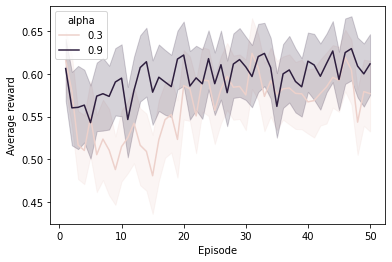

In [142]:
# initialize hyperparameters
gamma = .9
epsilon = 0.1

episodes, steps = 50, 20
    
results = []
df = pd.DataFrame()

for alpha in [0.3, 0.9]:
    
    print(alpha)
    avg_rewards = []
    
    # repeat for some number of iterations
    for _ in range(100):
        
        # initialize Q and the chain
        Q = init_Q()
        transitions, R = init_chain()
        
        # calculate the average rewards
        avg_rewards = Qlearning(Q, transitions, R, gamma, alpha, epsilon, episodes, steps)[1]
        
        # add them to a dataframe
        df1 = pd.DataFrame()
        df1['Episode'] = np.arange(episodes)+1
        df1['Average reward'] = avg_rewards
        df1['alpha'] = alpha
        df1['epsilon'] = epsilon
        
        # concatenate this iteration's average rewards to the other average rewards
        df = pd.concat([df, df1], ignore_index=True)

# make a lineplot with averages and CI
sns.lineplot(data=df, x="Episode", y="Average reward", hue="alpha",  ci=95)

plt.savefig(f'alpha_5_states_{episodes,steps,epsilon}.png', bbox_inches='tight', dpi=300)
plt.show()

0.01
0.1
0.2


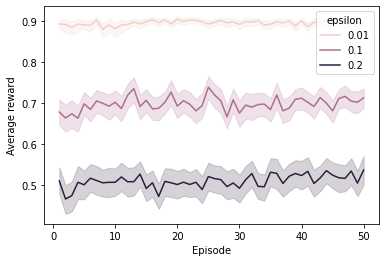

In [149]:
# initialize hyperparameters
gamma = .9
alpha = .9

episodes, steps = 50, 50

results = []
df = pd.DataFrame()

for epsilon in [0.01, 0.1, 0.2]:
    
    print(epsilon)
    avg_rewards = []
    
    # repeat for some number of iterations
    for _ in range(100):
        
        # initialize Q and the chain
        Q = init_Q()
        transitions, R = init_chain()
        
        # calculate the average rewards
        avg_rewards = Qlearning(Q, transitions, R, gamma, alpha, epsilon, episodes, steps)[1]
        
        # add them to a dataframe
        df1 = pd.DataFrame()
        df1['Episode'] = np.arange(episodes)+1
        df1['Average reward'] = avg_rewards
        df1['alpha'] = alpha
        df1['epsilon'] = epsilon
        
        # concatenate this iteration's average rewards to the other average rewards
        df = pd.concat([df, df1], ignore_index=True)

# make a lineplot with averages and CI
sns.lineplot(data=df, x="Episode", y="Average reward", hue="epsilon",  ci=95)

# plt.savefig(f'epsilon_5_states_{episodes,steps,alpha}.png', bbox_inches='tight', dpi=300)
plt.show()

# 4. Q-learning with 10 states (epsilon greedy)

In [39]:
def init_Q_10():
    return np.zeros((10,2))

def init_chain_10():
    
    # for each state, action 1 and action 2
    transitions = {0: [1, 0], 
                   1: [2, 0], 
                   2: [3, 0], 
                   3: [4, 0],
                   4: [5, 0],
                   5: [6, 0],
                   6: [7, 0],
                   7: [8, 0],
                   8: [9, 0],
                   9: [9, 0]}
    
    # rewards for each state's actions
    R = np.array([[0, 0.2],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [0, 0  ],
                  [1, 0  ]])
    
    return transitions, R

In [40]:
# initialize Q and the chain
Q = init_Q_10()
transitions, R = init_chain_10()

# initialize hyperparameters
gamma = .9
alpha = 0.9
epsilon = 0.1

episodes, steps = 500, 500

Q, episode_history = Qlearning(Q, transitions, R, gamma, alpha, epsilon, episodes, steps)
Q

array([[ 3.87420489,  3.6867844 ],
       [ 4.3046721 ,  3.4867844 ],
       [ 4.782969  ,  3.4867844 ],
       [ 5.31441   ,  3.4867844 ],
       [ 5.9049    ,  3.4867844 ],
       [ 6.561     ,  3.4867844 ],
       [ 7.29      ,  3.4867844 ],
       [ 8.1       ,  3.4867844 ],
       [ 9.        ,  3.4867844 ],
       [10.        ,  3.4867844 ]])

0.3
0.9


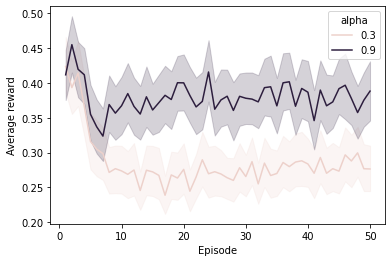

In [164]:
# initialize hyperparameters
gamma = .9
epsilon = 0.1

episodes, steps = 50, 40
    
results = []
df = pd.DataFrame()

for alpha in [0.3, 0.9]:
    
    print(alpha)
    avg_rewards = []
    
    # repeat for some number of iterations
    for _ in range(100):
        
        # initialize Q and the chain
        Q = init_Q_10()
        transitions, R = init_chain_10()
        
        # calculate the average rewards
        avg_rewards = Qlearning(Q, transitions, R, gamma, alpha, epsilon, episodes, steps)[1]
        
        # add them to a dataframe
        df1 = pd.DataFrame()
        df1['Episode'] = np.arange(episodes)+1
        df1['Average reward'] = avg_rewards
        df1['alpha'] = alpha
        df1['epsilon'] = epsilon
        
        # concatenate this iteration's average rewards to the other average rewards
        df = pd.concat([df, df1], ignore_index=True)

# make a lineplot with averages and CI
sns.lineplot(data=df, x="Episode", y="Average reward", hue="alpha",  ci=95)

plt.savefig(f'alpha_10_states_{episodes,steps,epsilon}.png', bbox_inches='tight', dpi=300)
plt.show()

0.01
0.05
0.1
0.2


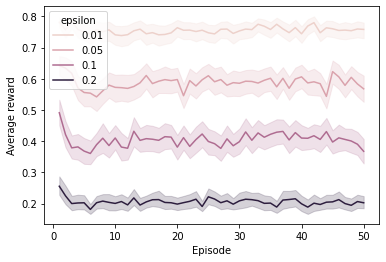

In [163]:
# initialize hyperparameters
gamma = .9
alpha = .9

episodes, steps = 50, 50

results = []
df = pd.DataFrame()

for epsilon in [0.01, 0.05, 0.10, 0.2]:
    
    print(epsilon)
    avg_rewards = []
    
    # repeat for some number of iterations
    for _ in range(100):
        
        # initialize Q and the chain
        Q = init_Q_10()
        transitions, R = init_chain_10()
        
        # calculate the average rewards
        avg_rewards = Qlearning(Q, transitions, R, gamma, alpha, epsilon, episodes, steps)[1]
        
        # add them to a dataframe
        df1 = pd.DataFrame()
        df1['Episode'] = np.arange(episodes)+1
        df1['Average reward'] = avg_rewards
        df1['alpha'] = alpha
        df1['epsilon'] = epsilon
        
        # concatenate this iteration's average rewards to the other average rewards
        df = pd.concat([df, df1], ignore_index=True)

# make a lineplot with averages and CI
sns.lineplot(data=df, x="Episode", y="Average reward", hue="epsilon",  ci=95)

plt.savefig(f'epsilon_10_states_{episodes,steps,alpha}.png', bbox_inches='tight', dpi=300)
plt.show()